In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")


In [ ]:
# Load CSV
df = pd.read_csv("/content/HUPA0001P.csv", sep=';')

# Preview the first few rows
df.head()


,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-06-13T18:40:00,332.0,6.3595,82.322835,34.0,0.091667,0.0,0.0
1,2018-06-13T18:45:00,326.0,7.7280,83.740157,0.0,0.091667,0.0,0.0
2,2018-06-13T18:50:00,330.0,4.7495,80.525180,0.0,0.091667,0.0,0.0
3,2018-06-13T18:55:00,324.0,6.3595,89.129032,20.0,0.091667,0.0,0.0
4,2018-06-13T19:00:00,306.0,5.1520,92.495652,0.0,0.075000,0.0,0.0


In [ ]:
# Dataset shape and columns
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("Columns:", df.columns.tolist())

# Data types and missing values
print("\nData info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nStatistical summary:")
print(df.describe())


Rows: 4096, Columns: 8
Columns: ['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate', 'bolus_volume_delivered', 'carb_input']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time                    4096 non-null   object 
 1   glucose                 4096 non-null   float64
 2   calories                4096 non-null   float64
 3   heart_rate              4096 non-null   float64
 4   steps                   4096 non-null   float64
 5   basal_rate              4096 non-null   float64
 6   bolus_volume_delivered  4096 non-null   float64
 7   carb_input              4096 non-null   float64
dtypes: float64(7), object(1)
memory usage: 256.1+ KB
None

Missing values per column:
time                      0
glucose                   0
calories                  0
heart_rate                0
steps       

In [ ]:
# Convert 'time' column to datetime if it exists
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    print(df['time'].head())


0   2018-06-13 18:40:00
1   2018-06-13 18:45:00
2   2018-06-13 18:50:00
3   2018-06-13 18:55:00
4   2018-06-13 19:00:00
Name: time, dtype: datetime64[ns]


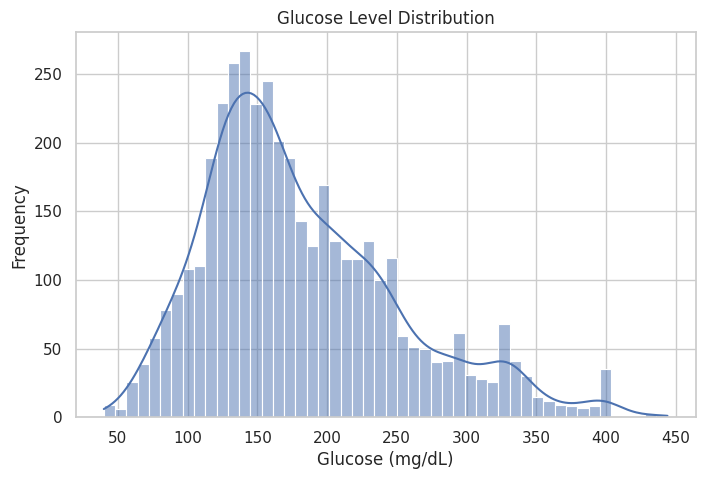

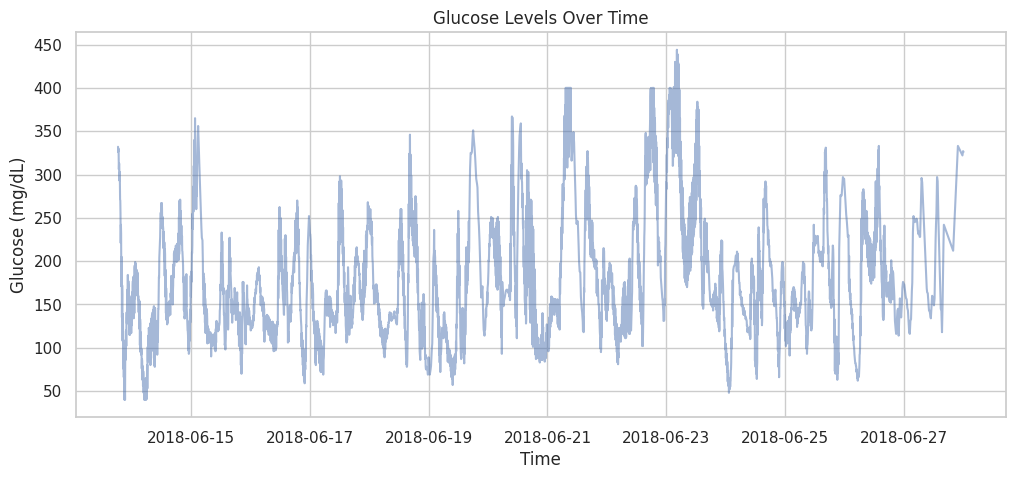

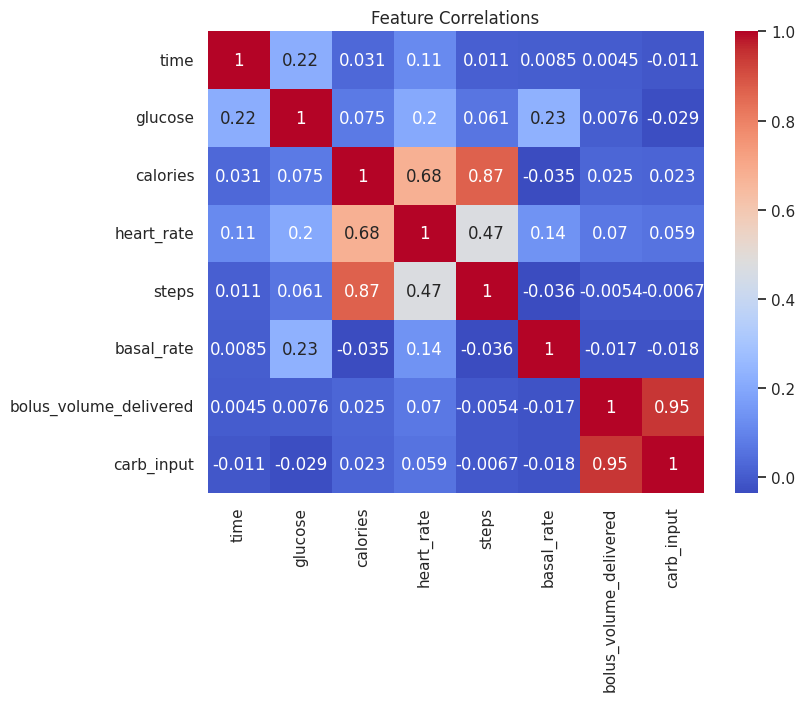

In [ ]:
# 1. Glucose distribution
plt.figure(figsize=(8,5))
sns.histplot(df['glucose'], bins=50, kde=True)
plt.title("Glucose Level Distribution")
plt.xlabel("Glucose (mg/dL)")
plt.ylabel("Frequency")
plt.show()

# 2. Glucose over time
plt.figure(figsize=(12,5))
plt.plot(df['time'], df['glucose'], alpha=0.5)
plt.title("Glucose Levels Over Time")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.show()

# 3. Correlation heatmap (numeric columns)
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


Plotting data from 2018-06-13 18:40:00 to 2018-06-14 18:40:00


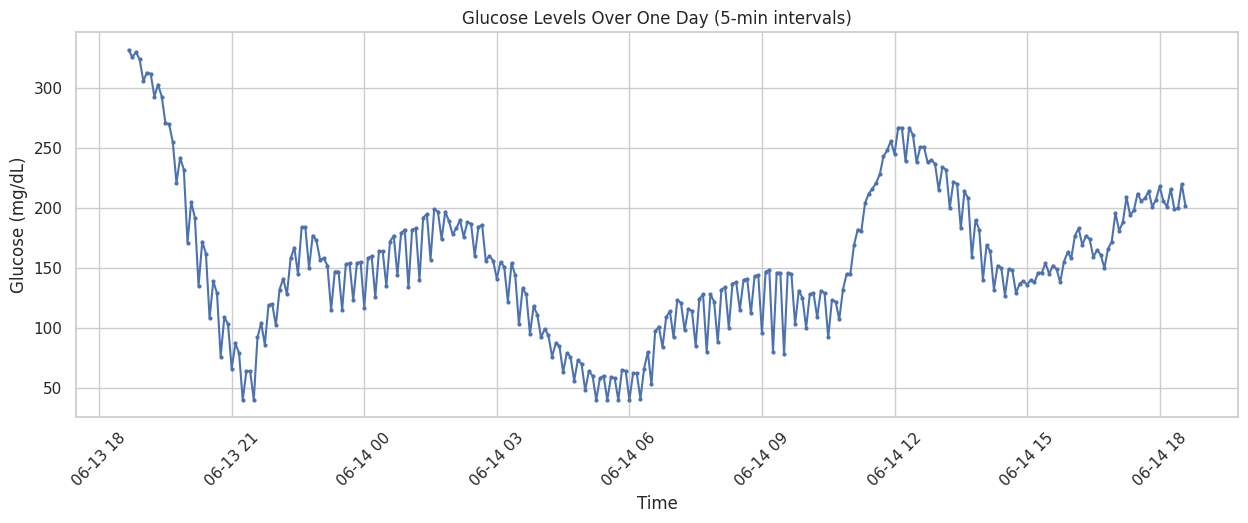

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# Choose the first day in the dataset
start_time = df['time'].min()
end_time = start_time + pd.Timedelta(days=1)

df_day = df[(df['time'] >= start_time) & (df['time'] < end_time)]
print(f"Plotting data from {start_time} to {end_time}")

plt.figure(figsize=(15,5))
plt.plot(df_day['time'], df_day['glucose'], marker='o', markersize=2, linestyle='-')
plt.title("Glucose Levels Over One Day (5-min intervals)")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-1511493924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['total_insulin'] = df_day['basal_rate'] + df_day['bolus_volume_delivered']


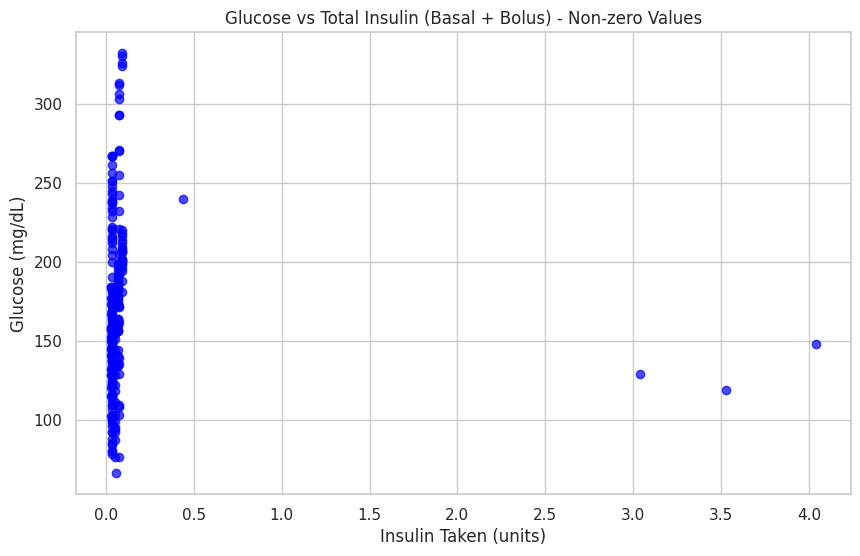

In [ ]:
# Calculate total insulin
df_day['total_insulin'] = df_day['basal_rate'] + df_day['bolus_volume_delivered']

# Keep only rows where insulin > 0
df_insulin = df_day[df_day['total_insulin'] > 0]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
plt.scatter(df_insulin['total_insulin'], df_insulin['glucose'], alpha=0.7, color='blue')
plt.title("Glucose vs Total Insulin (Basal + Bolus) - Non-zero Values")
plt.xlabel("Insulin Taken (units)")
plt.ylabel("Glucose (mg/dL)")
plt.show()


<Axes: >

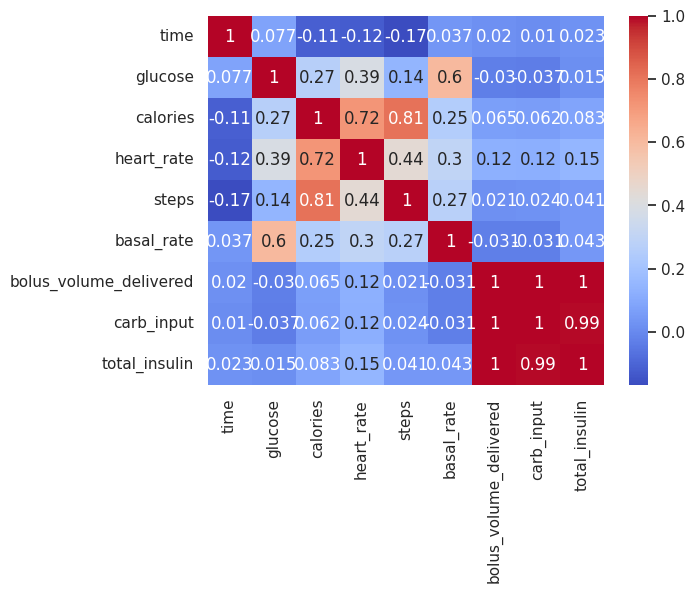

In [ ]:
import seaborn as sns
sns.heatmap(df_day.corr(), annot=True, cmap='coolwarm')


In [ ]:
# ====== Multi-patient dataset preparation ======
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import glob

# ====== Load all patient files ======
all_files = sorted(glob.glob("/content/HUPA-UCM Diabetes Dataset/HUPA*.csv"))  # assumes files are in /content/
print("Found files:", all_files)

# Assign patient IDs
patients_data = []
for i, file in enumerate(all_files):
    df = pd.read_csv(file, sep=';')
    df.columns = df.columns.str.strip()
    df['time'] = pd.to_datetime(df['time'])
    df['patient_id'] = i+1  # assign patient ID
    # Total insulin
    df['total_insulin'] = df['basal_rate'] + df['bolus_volume_delivered']
    # Lag features
    df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
    df['glucose_lag_10'] = df['glucose'].shift(2).fillna(method='bfill')
    # Time features
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    patients_data.append(df)

# Concatenate all patients
data = pd.concat(patients_data, ignore_index=True)

# ====== Feature & Target Selection ======
features = ['total_insulin', 'carb_input', 'heart_rate', 'steps', 'calories',
            'glucose_lag_5', 'glucose_lag_10', 'hour', 'minute']
target = 'glucose'

X = data[features]
y = data[target]

# ====== Patient-level Split ======
train_patients = list(range(1, 21))   # Patients 1-20 for training
val_patients = list(range(21, 25))    # Patients 21-24 for validation
test_patients = list(range(25, 29))   # Patients 25-28 for testing

X_train = X[data['patient_id'].isin(train_patients)]
y_train = y[data['patient_id'].isin(train_patients)]

X_val = X[data['patient_id'].isin(val_patients)]
y_val = y[data['patient_id'].isin(val_patients)]

X_test = X[data['patient_id'].isin(test_patients)]
y_test = y[data['patient_id'].isin(test_patients)]

# ====== Feature Scaling ======
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ====== Random Forest Model ======
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

# ====== Validation Metrics ======
y_val_pred = rf.predict(X_val_scaled)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)
print("Validation RMSE:", rmse_val)
print("Validation R2:", r2_val)

# ====== Test Metrics ======
y_test_pred = rf.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
print("Test RMSE:", rmse_test)
print("Test R2:", r2_test)


/tmp/ipython-input-2192006836.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
/tmp/ipython-input-2192006836.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_10'] = df['glucose'].shift(2).fillna(method='bfill')


Validation RMSE: 16.898263373029042
Validation R2: 0.8858700622919391
Test RMSE: 18.04623370085417
Test R2: 0.9203034229242236


In [ ]:
# ====== XGBoost for a single patient ======
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# ====== Load patient data ======
df = pd.read_csv("/content/HUPA0001P.csv", sep=';')
df.columns = df.columns.str.strip()
df['time'] = pd.to_datetime(df['time'])

# ====== Feature Engineering ======
df['total_insulin'] = df['basal_rate'] + df['bolus_volume_delivered']
df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
df['glucose_lag_10'] = df['glucose'].shift(2).fillna(method='bfill')
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

features = ['total_insulin', 'carb_input', 'heart_rate', 'steps', 'calories',
            'glucose_lag_5', 'glucose_lag_10', 'hour', 'minute']
target = 'glucose'

X = df[features]
y = df[target]

# ====== Train / Validation / Test Split (sequential) ======
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# ====== Feature Scaling (optional) ======
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ====== Train XGBoost Regressor ======
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train,
              eval_set=[(X_val_scaled, y_val)],

              verbose=10)

# ====== Validation Metrics ======
y_val_pred = xgb_model.predict(X_val_scaled)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)
print("Validation RMSE:", rmse_val)
print("Validation R2:", r2_val)

# ====== Test Metrics ======
y_test_pred = xgb_model.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
print("Test RMSE:", rmse_test)
print("Test R2:", r2_test)


[0]	validation_0-rmse:50.63078


/tmp/ipython-input-1395851655.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
/tmp/ipython-input-1395851655.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_10'] = df['glucose'].shift(2).fillna(method='bfill')


[10]	validation_0-rmse:32.96566
[20]	validation_0-rmse:24.15598
[30]	validation_0-rmse:19.30393
[40]	validation_0-rmse:17.22187
[50]	validation_0-rmse:16.48498
[60]	validation_0-rmse:16.28584
[70]	validation_0-rmse:16.34806
[80]	validation_0-rmse:16.42400
[90]	validation_0-rmse:16.62166
[100]	validation_0-rmse:16.68996
[110]	validation_0-rmse:16.72945
[120]	validation_0-rmse:16.88661
[130]	validation_0-rmse:17.04102
[140]	validation_0-rmse:17.08877
[150]	validation_0-rmse:17.20003
[160]	validation_0-rmse:17.25414
[170]	validation_0-rmse:17.29857
[180]	validation_0-rmse:17.35037
[190]	validation_0-rmse:17.40373
[200]	validation_0-rmse:17.46471
[210]	validation_0-rmse:17.50922
[220]	validation_0-rmse:17.54089
[230]	validation_0-rmse:17.60698
[240]	validation_0-rmse:17.64069
[250]	validation_0-rmse:17.69027
[260]	validation_0-rmse:17.74152
[270]	validation_0-rmse:17.73226
[280]	validation_0-rmse:17.77341
[290]	validation_0-rmse:17.80739
[300]	validation_0-rmse:17.83085
[310]	validation_0-

/tmp/ipython-input-1848124646.py:314: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


Data loaded successfully!
Data shape: (4096, 8)
Date range: 2018-06-13 18:40:00 to 2018-06-27 23:55:00
Training DQN agent...
Episode 0, Average Score: 6602.50, Average Glucose: 180.44
Episode 100, Average Score: 7098.94, Average Glucose: 180.44
Episode 200, Average Score: 7882.20, Average Glucose: 180.44
Episode 300, Average Score: 7706.53, Average Glucose: 180.44
Episode 400, Average Score: 7601.03, Average Glucose: 180.44
Model saved!
Analyzing policy...

Sample Recommendations:
            timestamp  current_glucose basal_recommendation  \
0 2018-06-13 19:40:00            255.0             Decrease   
1 2018-06-13 19:45:00            221.0             Decrease   
2 2018-06-13 19:50:00            242.0             Decrease   
3 2018-06-13 19:55:00            232.0             Decrease   
4 2018-06-13 20:00:00            171.0             Decrease   
5 2018-06-13 20:05:00            205.0             Decrease   
6 2018-06-13 20:10:00            192.0             Decrease   
7 2018-06-

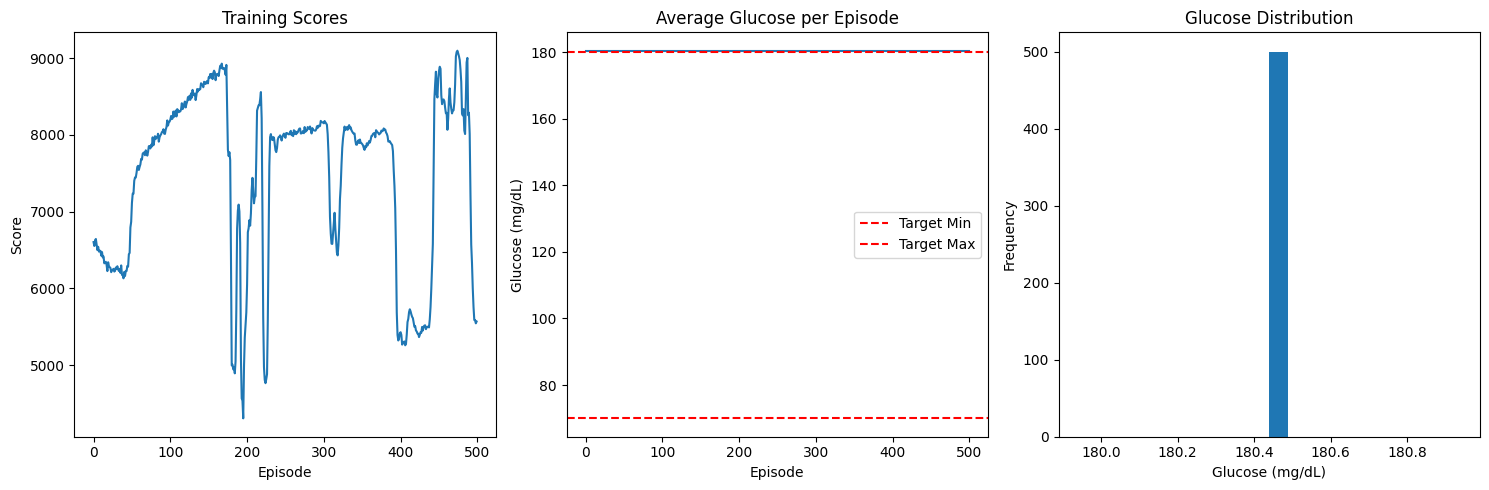

Recommendations saved to diabetes_management_recommendations.csv


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

class DiabetesEnvironment:
    def __init__(self, data, lookback=12, prediction_horizon=6):
        self.data = data.reset_index(drop=True)
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.current_step = lookback
        self.max_steps = len(data) - lookback - prediction_horizon

        # Define action space: [basal_adjustment, bolus_dose, carb_intake]
        # Actions: 0: decrease, 1: maintain, 2: increase (for basal)
        # Bolus: 0: no bolus, 1: small bolus, 2: medium bolus, 3: large bolus
        # Carbs: 0: no carbs, 1: small snack, 2: medium meal, 3: large meal
        self.n_actions = 12  # 3 basal actions × 4 bolus actions × 4 carb actions

        # State: [glucose, calories, heart_rate, steps, basal_rate, recent_bolus, recent_carbs, glucose_trend]
        self.state_size = lookback * 8

        # Glucose targets
        self.target_min = 70
        self.target_max = 180
        self.critical_low = 55
        self.critical_high = 250

    def get_state(self, step):
        start_idx = step - self.lookback
        end_idx = step

        state_data = self.data.iloc[start_idx:end_idx].copy()

        # Normalize features
        state = []
        for i in range(len(state_data)):
            row = state_data.iloc[i]
            # Glucose (normalize 0-400)
            glucose_norm = row['glucose'] / 400.0

            # Calories (normalize 0-50)
            calories_norm = row['calories'] / 50.0

            # Heart rate (normalize 0-200)
            hr_norm = row['heart_rate'] / 200.0

            # Steps (normalize 0-500)
            steps_norm = row['steps'] / 500.0

            # Basal rate (normalize 0-0.15)
            basal_norm = row['basal_rate'] / 0.15

            # Recent bolus (normalize 0-10)
            bolus_norm = row['bolus_volume_delivered'] / 10.0

            # Recent carbs (normalize 0-50)
            carbs_norm = row['carb_input'] / 50.0

            # Glucose trend (derived)
            if i > 0:
                prev_glucose = state_data.iloc[i-1]['glucose']
                trend = (row['glucose'] - prev_glucose) / 40.0  # normalize
            else:
                trend = 0

            state.extend([glucose_norm, calories_norm, hr_norm, steps_norm,
                         basal_norm, bolus_norm, carbs_norm, trend])

        return np.array(state)

    def decode_action(self, action):
        # Decode composite action
        basal_action = action // 16  # 0,1,2
        bolus_action = (action % 16) // 4  # 0,1,2,3
        carb_action = action % 4  # 0,1,2,3

        return basal_action, bolus_action, carb_action

    def step(self, action):
        current_data = self.data.iloc[self.current_step]
        basal_action, bolus_action, carb_action = self.decode_action(action)

        # Calculate future glucose (simplified prediction)
        future_step = min(self.current_step + self.prediction_horizon, len(self.data) - 1)
        future_glucose = self.data.iloc[future_step]['glucose']
        current_glucose = current_data['glucose']

        # Calculate reward
        reward = self.calculate_reward(current_glucose, future_glucose, basal_action,
                                     bolus_action, carb_action, current_data)

        # Update step
        self.current_step += 1
        done = self.current_step >= self.max_steps

        next_state = self.get_state(self.current_step) if not done else None

        return next_state, reward, done, {
            'current_glucose': current_glucose,
            'future_glucose': future_glucose,
            'basal_action': basal_action,
            'bolus_action': bolus_action,
            'carb_action': carb_action
        }

    def calculate_reward(self, current_glucose, future_glucose, basal_action,
                        bolus_action, carb_action, current_data):
        reward = 0

        # Glucose target reward
        if self.target_min <= future_glucose <= self.target_max:
            reward += 10  # Good range
        elif future_glucose < self.critical_low:
            reward -= 20  # Critical low
        elif future_glucose > self.critical_high:
            reward -= 15  # Critical high
        elif future_glucose < self.target_min:
            reward -= 5   # Mild low
        elif future_glucose > self.target_max:
            reward -= 3   # Mild high

        # Stability reward (prevent rapid changes)
        glucose_change = abs(future_glucose - current_glucose)
        if glucose_change < 10:
            reward += 2
        elif glucose_change > 40:
            reward -= 2

        # Action cost penalties
        if bolus_action > 0:
            reward -= 0.5 * bolus_action  # Small penalty for bolus

        if carb_action > 0:
            reward -= 0.3 * carb_action  # Small penalty for carbs

        # Basal adjustment penalty (encourage stability)
        if basal_action != 1:  # If not "maintain"
            reward -= 0.2

        # Physical activity consideration
        if current_data['steps'] > 100 and bolus_action > 1:
            reward -= 1  # Penalize large bolus during activity

        return reward

    def reset(self):
        self.current_step = self.lookback
        return self.get_state(self.current_step)

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size//2)
        self.fc4 = nn.Linear(hidden_size//2, action_size)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

class DiabetesDQNAgent:
    def __init__(self, state_size, action_size, hidden_size=128):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DQN(state_size, action_size, hidden_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.model(state)
        return np.argmax(q_values.cpu().data.numpy())

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([e[0] for e in batch]).to(self.device)
        actions = torch.LongTensor([e[1] for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(self.device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(self.device)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.model(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        loss = self.criterion(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filepath):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        checkpoint = torch.load(filepath)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

def train_diabetes_dqn(data, episodes=1000, lookback=12):
    env = DiabetesEnvironment(data, lookback=lookback)
    agent = DiabetesDQNAgent(env.state_size, env.n_actions)  # Fixed: use n_actions instead of action_size

    scores = []
    glucose_levels = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_glucose = []

        while True:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            if next_state is not None:
                agent.remember(state, action, reward, next_state, done)

            total_reward += reward
            episode_glucose.append(info['current_glucose'])

            state = next_state

            if done:
                break

        agent.replay()
        scores.append(total_reward)
        glucose_levels.append(np.mean(episode_glucose))

        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
            avg_glucose = np.mean(glucose_levels[-100:]) if len(glucose_levels) >= 100 else np.mean(glucose_levels)
            print(f"Episode {episode}, Average Score: {avg_score:.2f}, Average Glucose: {avg_glucose:.2f}")

    return agent, scores, glucose_levels

def analyze_policy(agent, data, lookback=12):
    env = DiabetesEnvironment(data, lookback=lookback)
    state = env.reset()

    recommendations = []

    while True:
        action = agent.act(state)
        basal_action, bolus_action, carb_action = env.decode_action(action)

        current_data = data.iloc[env.current_step]

        recommendation = {
            'timestamp': data.iloc[env.current_step]['time'],
            'current_glucose': current_data['glucose'],
            'basal_recommendation': ['Decrease', 'Maintain', 'Increase'][basal_action],
            'bolus_recommendation': ['None', 'Small', 'Medium', 'Large'][bolus_action],
            'carb_recommendation': ['None', 'Snack', 'Small Meal', 'Large Meal'][carb_action],
            'heart_rate': current_data['heart_rate'],
            'steps': current_data['steps']
        }

        recommendations.append(recommendation)

        next_state, _, done, _ = env.step(action)
        if done or next_state is None:
            break
        state = next_state

    return pd.DataFrame(recommendations)

# Load and preprocess your data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=';')
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)

    # Handle missing values if any
    df = df.fillna(method='ffill').fillna(0)

    return df

# Main execution
if __name__ == "__main__":
    # Load your data
    data = load_and_preprocess_data('HUPA0001P.csv')

    print("Data loaded successfully!")
    print(f"Data shape: {data.shape}")
    print(f"Date range: {data['time'].min()} to {data['time'].max()}")

    # Train the DQN agent
    print("Training DQN agent...")
    agent, scores, glucose_levels = train_diabetes_dqn(data, episodes=500, lookback=12)

    # Save the trained model
    agent.save('diabetes_dqn_model.pth')
    print("Model saved!")

    # Analyze the learned policy
    print("Analyzing policy...")
    recommendations = analyze_policy(agent, data)

    # Display some recommendations
    print("\nSample Recommendations:")
    print(recommendations.head(10))

    # Plot training results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(scores)
    plt.title('Training Scores')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(glucose_levels)
    plt.axhline(y=70, color='r', linestyle='--', label='Target Min')
    plt.axhline(y=180, color='r', linestyle='--', label='Target Max')
    plt.title('Average Glucose per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Glucose (mg/dL)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.hist([g for g in glucose_levels if 50 <= g <= 300], bins=20)
    plt.title('Glucose Distribution')
    plt.xlabel('Glucose (mg/dL)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Save recommendations
    recommendations.to_csv('diabetes_management_recommendations.csv', index=False)
    print("Recommendations saved to diabetes_management_recommendations.csv")

/tmp/ipython-input-3551228972.py:389: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


Training Enhanced DQN with Safety Constraints...
Episode 0, Avg Score: 213.70, Avg Glucose: 133.45, Safety Issues: 25.00
Episode 50, Avg Score: 372.94, Avg Glucose: 133.45, Safety Issues: 17.26
Episode 100, Avg Score: 408.82, Avg Glucose: 133.45, Safety Issues: 14.68
Episode 150, Avg Score: 380.08, Avg Glucose: 133.45, Safety Issues: 18.86
Episode 200, Avg Score: 501.04, Avg Glucose: 133.45, Safety Issues: 5.72
Episode 250, Avg Score: 592.04, Avg Glucose: 133.45, Safety Issues: 5.80
Episode 300, Avg Score: 538.30, Avg Glucose: 133.45, Safety Issues: 6.44
Episode 350, Avg Score: 506.08, Avg Glucose: 133.45, Safety Issues: 7.72
Episode 400, Avg Score: 405.92, Avg Glucose: 133.45, Safety Issues: 12.94
Episode 450, Avg Score: 335.50, Avg Glucose: 133.45, Safety Issues: 20.10
Analyzing learned policy...
Policy Safety: 98.0% of recommendations are safe

Safe Recommendations Sample (3983 total):
            timestamp  current_glucose basal_action bolus_action carb_action  \
0 2018-06-13 19:40

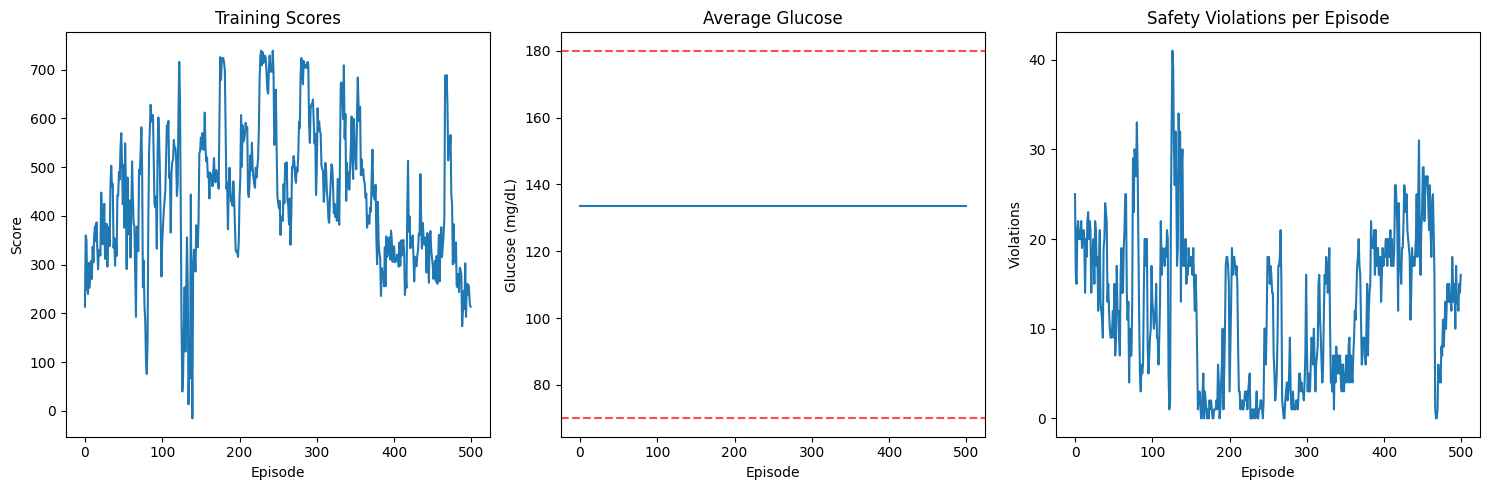

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

class ImprovedDiabetesEnvironment:
    def __init__(self, data, lookback=12, prediction_horizon=6):
        self.data = data.reset_index(drop=True)
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.current_step = lookback
        self.max_steps = len(data) - lookback - prediction_horizon

        # Safer action space
        self.n_actions = 8  # Reduced complexity: 2 basal × 2 bolus × 2 carb actions

        # Enhanced state representation
        self.state_size = lookback * 6  # Key features only

        # Medical safety parameters
        self.target_min = 70
        self.target_max = 180
        self.critical_low = 55
        self.critical_high = 250

    def get_state_representation(self, step):
        """Enhanced state representation with clinical features"""
        start_idx = step - self.lookback
        end_idx = step

        state_data = self.data.iloc[start_idx:end_idx]

        state = []
        for i in range(len(state_data)):
            row = state_data.iloc[i]

            # Core clinical features
            glucose_norm = row['glucose'] / 400.0
            hr_norm = row['heart_rate'] / 200.0
            steps_norm = min(row['steps'] / 100.0, 1.0)  # Cap at 1.0
            basal_norm = row['basal_rate'] / 0.15

            # Derived clinical features
            if i > 0:
                prev_glucose = state_data.iloc[i-1]['glucose']
                glucose_trend = (row['glucose'] - prev_glucose) / 20.0  # More sensitive trend
                glucose_trend = np.clip(glucose_trend, -2, 2)  # Bound trends
            else:
                glucose_trend = 0

            # Risk indicator
            glucose_risk = 0
            if row['glucose'] < 70: glucose_risk = -1
            elif row['glucose'] > 180: glucose_risk = 1

            state.extend([glucose_norm, hr_norm, steps_norm, basal_norm,
                         glucose_trend, glucose_risk])

        return np.array(state)

    def decode_action(self, action):
        """Simplified action decoding with safety"""
        basal_action = (action // 4) % 2  # 0=maintain, 1=adjust
        bolus_action = (action // 2) % 2  # 0=no, 1=yes
        carb_action = action % 2          # 0=no, 1=yes

        return basal_action, bolus_action, carb_action

    def step(self, action):
        current_data = self.data.iloc[self.current_step]
        current_glucose = current_data['glucose']

        basal_action, bolus_action, carb_action = self.decode_action(action)

        # Look ahead for future glucose
        future_step = min(self.current_step + self.prediction_horizon, len(self.data) - 1)
        future_glucose = self.data.iloc[future_step]['glucose']

        # Enhanced reward with safety constraints
        reward = self.calculate_safe_reward(current_glucose, future_glucose,
                                          basal_action, bolus_action, carb_action,
                                          current_data)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        next_state = self.get_state_representation(self.current_step) if not done else None

        return next_state, reward, done, {
            'current_glucose': current_glucose,
            'future_glucose': future_glucose,
            'basal_action': basal_action,
            'bolus_action': bolus_action,
            'carb_action': carb_action
        }

    def calculate_safe_reward(self, current_glucose, future_glucose,
                            basal_action, bolus_action, carb_action, current_data):
        """Enhanced reward function with medical safety"""
        reward = 0

        # Primary glucose target reward (shaped)
        if self.target_min <= future_glucose <= self.target_max:
            reward += 10
        else:
            # Distance-based penalty
            if future_glucose < self.target_min:
                distance = self.target_min - future_glucose
                reward -= distance * 0.5
            else:
                distance = future_glucose - self.target_max
                reward -= distance * 0.2

        # Critical safety penalties
        if future_glucose < self.critical_low:
            reward -= 25
        if future_glucose > self.critical_high:
            reward -= 20

        # Action safety constraints
        if current_glucose < 80 and bolus_action == 1:  # Bolus when low
            reward -= 15
        if current_glucose > 200 and carb_action == 1:  # Carbs when high
            reward -= 10
        if current_glucose < 70 and basal_action == 1:  # Adjust basal when low
            reward -= 10

        # Stability reward
        glucose_change = abs(future_glucose - current_glucose)
        if glucose_change < 15:
            reward += 3
        elif glucose_change > 60:
            reward -= 5

        # Activity-aware rewards
        if current_data['steps'] > 50:  # During activity
            if bolus_action == 1:  # Penalize bolus during activity
                reward -= 3
            if carb_action == 1:  # Reward carbs during activity if glucose trending down
                if current_glucose < 120:
                    reward += 2

        return reward

    def reset(self):
        self.current_step = self.lookback
        return self.get_state_representation(self.current_step)

class EnhancedDQNAgent:
    def __init__(self, state_size, action_size, k_neighbors=50, memory_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.k_neighbors = k_neighbors
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005  # Lower learning rate for stability
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Dual network for stability (DDQN)
        self.model = self._build_model().to(self.device)
        self.target_model = self._build_model().to(self.device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.SmoothL1Loss()  # Huber loss for stability

        # For k-NN experience selection
        self.nearest_neighbors = None
        self.state_memory = []

    def _build_model(self):
        """Enhanced network architecture"""
        return nn.Sequential(
            nn.Linear(self.state_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )

    def update_target_model(self):
        """Update target network weights"""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Store experience with state for k-NN lookup"""
        self.memory.append((state, action, reward, next_state, done))
        self.state_memory.append(state)

    def build_knn_index(self):
        """Build k-NN index for similar experience selection"""
        if len(self.state_memory) > self.k_neighbors:
            self.nearest_neighbors = NearestNeighbors(n_neighbors=self.k_neighbors, metric='euclidean')
            self.nearest_neighbors.fit(np.array(self.state_memory))

    def act(self, state, training=True):
        """Enhanced action selection with exploration"""
        if training and np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.cpu().data.numpy())

    def replay(self):
        """Enhanced experience replay with k-NN sampling"""
        if len(self.memory) < self.batch_size:
            return

        # Build k-NN index if needed
        if self.nearest_neighbors is None and len(self.state_memory) > self.k_neighbors:
            self.build_knn_index()

        if self.nearest_neighbors is not None:
            # Sample recent state as query
            query_state = random.choice(self.state_memory[-100:])  # Recent states
            query_state = np.array(query_state).reshape(1, -1)

            # Find similar experiences
            try:
                _, indices = self.nearest_neighbors.kneighbors(query_state)
                # Sample from similar experiences
                batch_indices = random.sample(list(indices[0]), min(self.batch_size, len(indices[0])))
                batch = [self.memory[i] for i in batch_indices if i < len(self.memory)]
            except:
                # Fallback to random sampling
                batch = random.sample(self.memory, self.batch_size)
        else:
            # Random sampling until k-NN is ready
            batch = random.sample(self.memory, self.batch_size)

        # Prepare batch data
        states = torch.FloatTensor([e[0] for e in batch]).to(self.device)
        actions = torch.LongTensor([e[1] for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(self.device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(self.device)

        # Double DQN update
        current_q = self.model(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.model(next_states).max(1)[1]
            next_q = self.target_model(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (self.gamma * next_q * ~dones)

        loss = self.criterion(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_enhanced_dqn(data, episodes=1000, lookback=12):
    """Enhanced training with the improved algorithm"""
    env = ImprovedDiabetesEnvironment(data, lookback=lookback)
    agent = EnhancedDQNAgent(env.state_size, env.n_actions)

    scores = []
    glucose_levels = []
    safety_violations = []

    target_update_freq = 10  # Update target network every 10 episodes

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_glucose = []
        safety_issues = 0

        for step in range(200):  # Limit steps per episode
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # Track safety violations
            current_glucose = info['current_glucose']
            if (current_glucose < 70 and info['bolus_action'] == 1) or \
               (current_glucose > 200 and info['carb_action'] == 1):
                safety_issues += 1

            if next_state is not None:
                agent.remember(state, action, reward, next_state, done)

            total_reward += reward
            episode_glucose.append(current_glucose)
            state = next_state

            if done:
                break

        # Train more frequently
        for _ in range(3):
            agent.replay()

        # Update target network
        if episode % target_update_freq == 0:
            agent.update_target_model()

        scores.append(total_reward)
        glucose_levels.append(np.mean(episode_glucose))
        safety_violations.append(safety_issues)

        if episode % 50 == 0:
            avg_score = np.mean(scores[-50:]) if len(scores) >= 50 else np.mean(scores)
            avg_glucose = np.mean(glucose_levels[-50:]) if len(glucose_levels) >= 50 else np.mean(glucose_levels)
            avg_safety = np.mean(safety_violations[-50:]) if len(safety_violations) >= 50 else np.mean(safety_violations)
            print(f"Episode {episode}, Avg Score: {avg_score:.2f}, Avg Glucose: {avg_glucose:.2f}, Safety Issues: {avg_safety:.2f}")

    return agent, scores, glucose_levels, safety_violations

def safe_policy_analysis(agent, data, lookback=12):
    """Analyze the learned policy with safety checks"""
    env = ImprovedDiabetesEnvironment(data, lookback=lookback)
    state = env.reset()

    recommendations = []
    safety_checks = []

    while True:
        action = agent.act(state, training=False)  # No exploration during evaluation
        basal_action, bolus_action, carb_action = env.decode_action(action)

        current_data = data.iloc[env.current_step]
        current_glucose = current_data['glucose']

        # Safety validation
        safety_ok = True
        safety_notes = []

        if current_glucose < 80 and bolus_action == 1:
            safety_ok = False
            safety_notes.append("Bolus recommended during low glucose")
        if current_glucose > 200 and carb_action == 1:
            safety_ok = False
            safety_notes.append("Carbs recommended during high glucose")
        if current_glucose < 70 and basal_action == 1:
            safety_ok = False
            safety_notes.append("Basal adjustment during hypoglycemia")

        recommendation = {
            'timestamp': current_data['time'],
            'current_glucose': current_glucose,
            'basal_action': 'Adjust' if basal_action == 1 else 'Maintain',
            'bolus_action': 'Yes' if bolus_action == 1 else 'No',
            'carb_action': 'Yes' if carb_action == 1 else 'No',
            'safety_ok': safety_ok,
            'safety_notes': '; '.join(safety_notes) if safety_notes else 'Safe',
            'heart_rate': current_data['heart_rate'],
            'steps': current_data['steps']
        }

        recommendations.append(recommendation)
        safety_checks.append(safety_ok)

        next_state, _, done, _ = env.step(action)
        if done or next_state is None:
            break
        state = next_state

    safety_percentage = (sum(safety_checks) / len(safety_checks)) * 100
    print(f"Policy Safety: {safety_percentage:.1f}% of recommendations are safe")

    return pd.DataFrame(recommendations)

# Load and run
def load_data():
    df = pd.read_csv('HUPA0001P.csv', delimiter=';')
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    df = df.fillna(method='ffill').fillna(0)
    return df

if __name__ == "__main__":
    data = load_data()

    print("Training Enhanced DQN with Safety Constraints...")
    agent, scores, glucose_levels, safety_violations = train_enhanced_dqn(data, episodes=500, lookback=12)

    print("Analyzing learned policy...")
    recommendations = safe_policy_analysis(agent, data)

    # Display safe recommendations
    safe_recommendations = recommendations[recommendations['safety_ok'] == True]
    print(f"\nSafe Recommendations Sample ({len(safe_recommendations)} total):")
    print(safe_recommendations.head(10))

    # Plot results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(scores)
    plt.title('Training Scores')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(glucose_levels)
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.7)
    plt.axhline(y=180, color='r', linestyle='--', alpha=0.7)
    plt.title('Average Glucose')
    plt.xlabel('Episode')
    plt.ylabel('Glucose (mg/dL)')

    plt.subplot(1, 3, 3)
    plt.plot(safety_violations)
    plt.title('Safety Violations per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Violations')

    plt.tight_layout()
    plt.show()